In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.special import inv_boxcox

In [12]:
# 将附件一.xlsx中的数据读取到dataframe中
df = pd.read_excel('../data/附件一：已结束项目任务数据.xls')
print(df)

# 对dataframe中的其中标签为“经度”“纬度”两列数据依据3sigma准则进行剔除进行异常值剔除（似的剔除异常值后对dataframe不再包括异常值所在行），并打印出异常值
# Calculate mean and standard deviation for longitude and latitude columns
mean_longitude = df['任务gps经度'].mean()
std_longitude = df['任务gps经度'].std()
mean_latitude = df['任务gps 纬度'].mean()
std_latitude = df['任务gps 纬度'].std()

# Identify outliers using 3-sigma rule for longitude column
outliers_longitude = df[(df['任务gps经度'] - mean_longitude) > 3 * std_longitude]
# Remove outliers from longitude column
df = df[(df['任务gps经度'] - mean_longitude) <= 3 * std_longitude]

# Identify outliers using 3-sigma rule for latitude column
outliers_latitude = df[(df['任务gps 纬度'] - mean_latitude) > 3 * std_latitude]
# Remove outliers from latitude column
df = df[(df['任务gps 纬度'] - mean_latitude) <= 3 * std_latitude]

# Print outliers
print("Outliers in longitude column:")
print(outliers_longitude)
print("Outliers in latitude column:")
print(outliers_latitude)
# 将剩余的df重新编号
df.reset_index(drop=True, inplace=True)
print(df)


# 主要是高纬异常值
# 将df除制定标签外的多余列删去
df.drop(['任务号码','任务标价','任务执行情况'], axis=1, inplace=True)
# 将df导出为excel
df.to_excel('../data/已结束项目任务数据(精简版).xlsx', index=False)

      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
0    A0001  22.566142  113.980837  66.0       0
1    A0002  22.686205  113.940525  65.5       0
2    A0003  22.576512  113.957198  65.5       1
3    A0004  22.564841  114.244571  75.0       0
4    A0005  22.558888  113.950723  65.5       0
..     ...        ...         ...   ...     ...
830  A0831  23.044062  113.125784  65.5       0
831  A0832  22.833262  113.280152  72.0       1
832  A0833  22.814676  113.827731  85.0       1
833  A0834  23.063674  113.771188  65.5       1
834  A0835  23.123294  113.110382  85.0       1

[835 rows x 5 columns]
Outliers in longitude column:
Empty DataFrame
Columns: [任务号码, 任务gps 纬度, 任务gps经度, 任务标价, 任务执行情况]
Index: []
Outliers in latitude column:
      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
296  A0297  23.878398  113.539711  70.0       1
297  A0298  23.723118  113.739427  75.0       1
302  A0303  23.816108  113.957929  75.0       1
      任务号码   任务gps 纬度     任务gps经度  任务标价  任务执行情况
0    A0001  22.566142  113

[[113.1921434   23.00210687]
 [113.30726789  23.26327808]
 [113.77002121  22.96106   ]
 [114.03741926  22.65468858]]


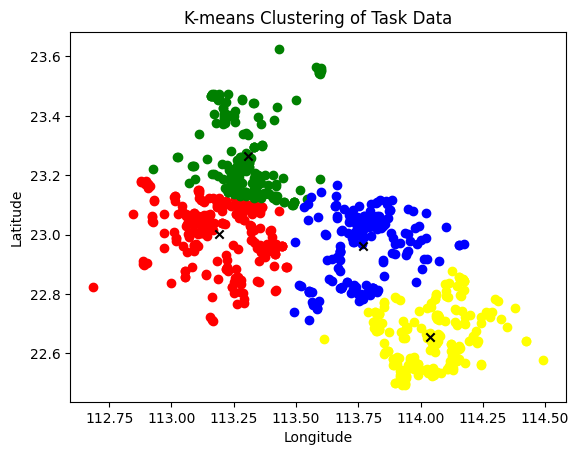

In [5]:
df
# 对df的两列数据构成的数据点进行k-means聚类分析

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
data = df[['任务gps经度', '任务gps 纬度']]
data = scaler.fit_transform(data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4)
df['cluster'] = kmeans.fit_predict(data)

centers = kmeans.cluster_centers_
# Inverse transform the cluster centers to the original scale
centers = scaler.inverse_transform(centers)
print(centers)

# Plot the clusters
fig, ax = plt.subplots()
colors = ['red', 'green', 'blue', 'yellow']
for i in range(4):
    points = df[df['cluster'] == i]
    ax.scatter(points['任务gps经度'], points['任务gps 纬度'], c=colors[i])
    ax.scatter(centers[i][0], centers[i][1], c='black', marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Task Data')
plt.show()



In [37]:
df = pd.read_excel('../data/附件二：会员信息数据.xlsx')
print(df)

       会员编号             会员位置(GPS)  预订任务限额  预订任务开始时间         信誉值
0     B0001  22.947097 113.679983     114  06:30:00  67997.3868
1     B0002  22.577792 113.966524     163  06:30:00  37926.5416
2     B0003  23.192458 113.347272     139  06:30:00  27953.0363
3     B0004   23.255965 113.31875      98  06:30:00  25085.6986
4     B0005    33.65205 116.97047      66  06:30:00  20919.0667
...     ...                   ...     ...       ...         ...
1872  B1873  22.840505 113.277245       1  08:00:00      0.0124
1873  B1874  23.069415 113.287606       1  08:00:00      0.0121
1874  B1875  23.333446 113.301736       1  08:00:00      0.0062
1875  B1876  22.693506 113.994101       1  08:00:00      0.0036
1876  B1877  23.133238 113.239864       1  08:00:00      0.0001

[1877 rows x 5 columns]


In [38]:
import pandas as pd

# 假设df是你的DataFrame

# 清理“会员位置(GPS)”列，移除多余的空格或逗号
df['会员位置(GPS)'] = df['会员位置(GPS)'].str.strip().str.replace(r'\s+', ' ', regex=True).str.replace(',', '')

# 检查清理后的每一行是否都能正确拆分成两列
df['拆分'] = df['会员位置(GPS)'].str.split(' ')

# 筛选出那些拆分后没有得到两列的行
invalid_rows = df[df['拆分'].apply(len) != 2]

if not invalid_rows.empty:
    print("清理后仍发现格式异常的行:")
    print(invalid_rows)
else:
    # 将'会员位置(GPS)'列拆分为两个新列：'纬度'和'经度'
    df[['纬度', '经度']] = pd.DataFrame(df['拆分'].tolist(), index=df.index)

    # 将新列的数据类型转换为浮点型
    df['纬度'] = df['纬度'].astype(float)
    df['经度'] = df['经度'].astype(float)

    # 删除临时列
    df.drop(columns=['拆分'], inplace=True)

    print(df)

       会员编号             会员位置(GPS)  预订任务限额  预订任务开始时间         信誉值         纬度  \
0     B0001  22.947097 113.679983     114  06:30:00  67997.3868  22.947097   
1     B0002  22.577792 113.966524     163  06:30:00  37926.5416  22.577792   
2     B0003  23.192458 113.347272     139  06:30:00  27953.0363  23.192458   
3     B0004   23.255965 113.31875      98  06:30:00  25085.6986  23.255965   
4     B0005    33.65205 116.97047      66  06:30:00  20919.0667  33.652050   
...     ...                   ...     ...       ...         ...        ...   
1872  B1873  22.840505 113.277245       1  08:00:00      0.0124  22.840505   
1873  B1874  23.069415 113.287606       1  08:00:00      0.0121  23.069415   
1874  B1875  23.333446 113.301736       1  08:00:00      0.0062  23.333446   
1875  B1876  22.693506 113.994101       1  08:00:00      0.0036  22.693506   
1876  B1877  23.133238 113.239864       1  08:00:00      0.0001  23.133238   

              经度  
0     113.679983  
1     113.966524  
2     

In [39]:
# 对dataframe中的其中标签为“经度”“纬度”两列数据依据3sigma准则进行剔除进行异常值剔除（似的剔除异常值后对dataframe不再包括异常值所在行），并打印出异常值
# Calculate mean and standard deviation for longitude and latitude columns

# df中的“会员位置(GPS)”一列数据格式为“纬度（空格）经度”，请提取为两个数列


mean_latitude = df['纬度'].mean()
mean_longitude = df['经度'].mean()
std_latitude = df['纬度'].std()
std_longitude = df['经度'].std()


# Identify outliers using 3-sigma rule for longitude column
outliers_longitude = df[(df['经度'] - mean_longitude) > 3 * std_longitude]
# Remove outliers from longitude column
df = df[(df['经度'] - mean_longitude) <= 3 * std_longitude]

# Identify outliers using 3-sigma rule for latitude column
outliers_latitude = df[(df['纬度'] - mean_latitude) > 3 * std_latitude]
# Remove outliers from latitude column
df = df[(df['纬度'] - mean_latitude) <= 3 * std_latitude]

# Print outliers
print("Outliers in longitude column:")
print(outliers_longitude)
print("Outliers in latitude column:")
print(outliers_latitude)
# 将剩余的df重新编号
df.reset_index(drop=True, inplace=True)
print(df)
# Create a new dataframe with only longitude and latitude columns
new_df = df[['会员编号', '经度', '纬度']].copy()
new_df.to_excel('../data/有效会员位置数据.xlsx', index=False)



Outliers in longitude column:
Empty DataFrame
Columns: [会员编号, 会员位置(GPS), 预订任务限额, 预订任务开始时间, 信誉值, 纬度, 经度]
Index: []
Outliers in latitude column:
       会员编号             会员位置(GPS)  预订任务限额  预订任务开始时间         信誉值          纬度  \
4     B0005    33.65205 116.97047      66  06:30:00  20919.0667   33.652050   
6     B0007  29.560903 106.239083      15  06:30:00  15729.3601   29.560903   
1174  B1175  113.131483 23.031824       1  06:36:00     19.9231  113.131483   

              经度  
4     116.970470  
6     106.239083  
1174   23.031824  
       会员编号             会员位置(GPS)  预订任务限额  预订任务开始时间         信誉值         纬度  \
0     B0001  22.947097 113.679983     114  06:30:00  67997.3868  22.947097   
1     B0002  22.577792 113.966524     163  06:30:00  37926.5416  22.577792   
2     B0003  23.192458 113.347272     139  06:30:00  27953.0363  23.192458   
3     B0004   23.255965 113.31875      98  06:30:00  25085.6986  23.255965   
4     B0006   22.262784 112.79768      72  06:30:00  18237.6295  22.262784